# **Pruning Demo**

This Pruning Demo is adapted from the **TinyML and Efficient Deep Learning Computing** Course by Song Han at MIT.

Contributions include visualization of magnitude based color scale of weights for all kernels of `conv1` layer of the model.

This colab notebook provides code and a framework for the demo used in the Pruning lecture of [MIT efficient AI course](https://efficientml.ai).

The neural network model definition and training schedule are adapted from [PyTorch example](https://github.com/pytorch/examples/blob/main/mnist/main.py).



In [ ]:
PRETRAINED_WEIGHTS = './pruning_demo_weights.pth'

# Setup

First, install the required packages and download the datasets and pretrained model. Here we use CIFAR10 dataset and VGG network which is the same as what we used in the Lab 0 tutorial.

In [ ]:
print('Installing torchprofile...')
!pip install torchprofile 1>/dev/null
print('All required packages have been successfully installed!')

Installing torchprofile...
All required packages have been successfully installed!


In [ ]:
import copy
import math
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm

from torchprofile import profile_macs

import torch.nn.functional as F

assert torch.cuda.is_available(), \
"The current runtime does not have CUDA support." \
"Please go to menu bar (Runtime - Change runtime type) and select GPU"

In [ ]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [ ]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: StepLR,
  callbacks = None
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer
    optimizer.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()

  # Update scheduler
  scheduler.step()

In [ ]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  verbose=True,
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False,
                              disable=not verbose):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

Helper Functions (Flops, Model Size calculation, etc.)

In [ ]:
def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)


def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

Define pruning functions.

In [ ]:
def fine_grained_prune(tensor: torch.Tensor, sparsity : float) -> torch.Tensor:
    """
    magnitude-based pruning for single tensor
    :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
    :param sparsity: float, pruning sparsity
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    :return:
        torch.(cuda.)Tensor, mask for zeros
    """
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()

    num_zeros = round(num_elements * sparsity)
    importance = tensor.abs()
    threshold = importance.view(-1).kthvalue(num_zeros).values
    mask = torch.gt(importance, threshold)
    tensor.mul_(mask)

    return mask

In [ ]:
class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # we only prune conv and fc weights
                if isinstance(sparsity_dict, dict):
                    masks[name] = fine_grained_prune(param, sparsity_dict[name])
                else:
                    assert(sparsity_dict < 1 and sparsity_dict >= 0)
                    if sparsity_dict > 0:
                        masks[name] = fine_grained_prune(param, sparsity_dict)
        return masks

Load the MNIST dataset.

In [ ]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
to_image = lambda t: (t*0.3081+0.1307).squeeze(0).to('cpu').numpy()

dataset = {}
for split in ["train", "test"]:
  dataset[split] = MNIST(
    "data",
    train=(split == "train"),
    download=(split == "train"),
    transform=transform,
  )

dataloader = {}
for split in ['train', 'test']:
  dataloader[split] = DataLoader(
    dataset[split],
    batch_size=256 if split == 'train' else 1000,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True
  )

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.18MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 137kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:06<00:00, 247kB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.89MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Create a set of test images for demo.

In [ ]:
demos = {0: 3, 1: 2, 2: 1, 3: 30, 4: 4, 5: 15, 6: 11, 7: 0, 8: 61, 9: 9}
demo_inputs, demo_images = [], []
for digit, index in demos.items():
    demo_inputs.append(copy.deepcopy(dataset['test'][index][0]))
    demo_images.append(to_image(demo_inputs[-1]))
demo_inputs = torch.stack(demo_inputs).cuda()

Create visualization for weight maps.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns

def visualize_weights(model, layer_name, title):
    """
    Visualize the weights of a specific layer as a heatmap with weight values annotated.

    Args:
        model (torch.nn.Module): The PyTorch model.
        layer_name (str): The name of the layer to visualize.
        title (str): Title for the plot.
    """

    weights = dict(model.named_parameters())[layer_name].detach().cpu().numpy()

    # Check if it's a convolutional layer
    if weights.ndim == 4:
        out_channels = weights.shape[0]
        in_channels = weights.shape[1]

        # Create subplots for each kernel (visualize only one input channel per kernel)
        cols = min(8, out_channels)
        rows = int(np.ceil(out_channels / cols))
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
        fig.suptitle(title, fontsize=16)

        for i in range(out_channels):
            row, col = divmod(i, cols)
            ax = axes[row, col] if rows > 1 else axes[col]
            kernel = weights[i, 0, :, :]

            # Use absolute values for coloring but keep signed values for annotations, helps with visualizing weight magnitudes!
            abs_kernel = np.abs(kernel)

            sns.heatmap(
                abs_kernel,
                annot=kernel,
                fmt=".2f",
                cmap=sns.light_palette("blue", as_cmap=True),
                cbar=False,
                square=True,
                ax=ax
            )
            ax.set_title(f"Kernel {i+1}")
            ax.axis("off")

        # Turn off unused subplots
        for i in range(out_channels, rows * cols):
            row, col = divmod(i, cols)
            if rows > 1:
                axes[row, col].axis("off")
            else:
                axes[col].axis("off")

        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()
    else:
        print(f"{layer_name} is not a convolutional layer.")


# Neural Network Model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1) # 1 x 32 x 3 x 3 = 288 parameters
        self.conv2 = nn.Conv2d(32, 64, 3, 1) # 32 x 64 x 3 x 3=18,432 paramters
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128) # 9216 x 128 = 1,179,648 parameters
        self.fc2 = nn.Linear(128, 10) # 128 x 10 = 1,280 parameters

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

model = Net().cuda()

# Let's Visualize the Demo Images

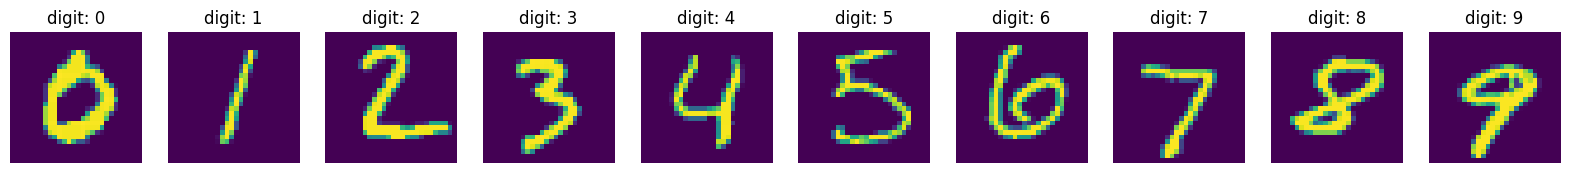

In [ ]:
def visualize(with_predictions=False):
    plt.figure(figsize=(20, 10))
    predictions = model(demo_inputs).argmax(dim=1) if with_predictions else None
    for digit, index in demos.items():
        plt.subplot(1, 10, digit + 1)
        plt.imshow(demo_images[digit])
        if predictions is None:
            plt.title(f"digit: {digit}")
        else:
            plt.title(f"digit: {digit}\npred: {int(predictions[digit])}")
        plt.axis('off')
    plt.show()

visualize()

# Pre-train Neural Network on MNIST

In [ ]:
# Training

'''
lr = 1.0
lr_step_gamma = 0.7
num_epochs = 5

optimizer = Adadelta(model.parameters(), lr=lr)
criterion = F.nll_loss
scheduler = StepLR(optimizer, step_size=1, gamma=lr_step_gamma)

best_accuracy = 0
best_checkpoint = dict()
for epoch in range(num_epochs):
    train(model, dataloader['train'], criterion, optimizer, scheduler)
    accuracy = evaluate(model, dataloader['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
        best_accuracy = accuracy
    print(f'    Epoch {epoch+1:>2d} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

print(f"=> loading best checkpoint")
model.load_state_dict(best_checkpoint['state_dict'])
recover_model = lambda: model.load_state_dict(best_checkpoint['state_dict'])
'''

# PRETRAINED_WEIGHTS = '/content/drive/Shareddrives/EEC174ABY Fall2024 (TA)/Lecture Slides/pruning_demo_weights.pth'
# torch.save(model.state_dict(), PRETRAINED_WEIGHTS)

In [ ]:
lr = 1.0
lr_step_gamma = 0.7
criterion = F.nll_loss
optimizer = Adadelta(model.parameters(), lr=lr)
criterion = F.nll_loss
scheduler = StepLR(optimizer, step_size=1, gamma=lr_step_gamma)

In [ ]:
# Load model
model.load_state_dict(torch.load(PRETRAINED_WEIGHTS))

<ipython-input-24-22b05c65e864>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(PRETRAINED_WEIGHTS))


# Let's First Evaluate the Accuracy and Model Size of Dense Model

Let's first evaluate the accuracy and model size of this model.

eval:   0%|          | 0/10 [00:00<?, ?it/s]

dense model has accuracy=98.98%
dense model has size=4.58 MiB


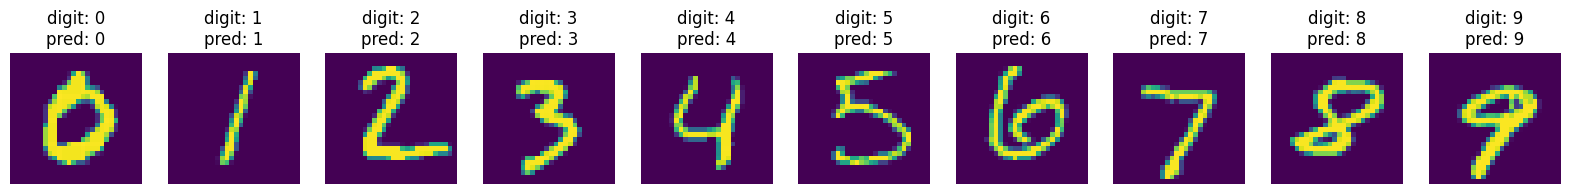

In [ ]:
dense_model_accuracy = evaluate(model, dataloader['test'])
dense_model_size = get_model_size(model)
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")
print(f"dense model has size={dense_model_size/MiB:.2f} MiB")
visualize(True)

# Visualize the conv1 Weights Before Pruning

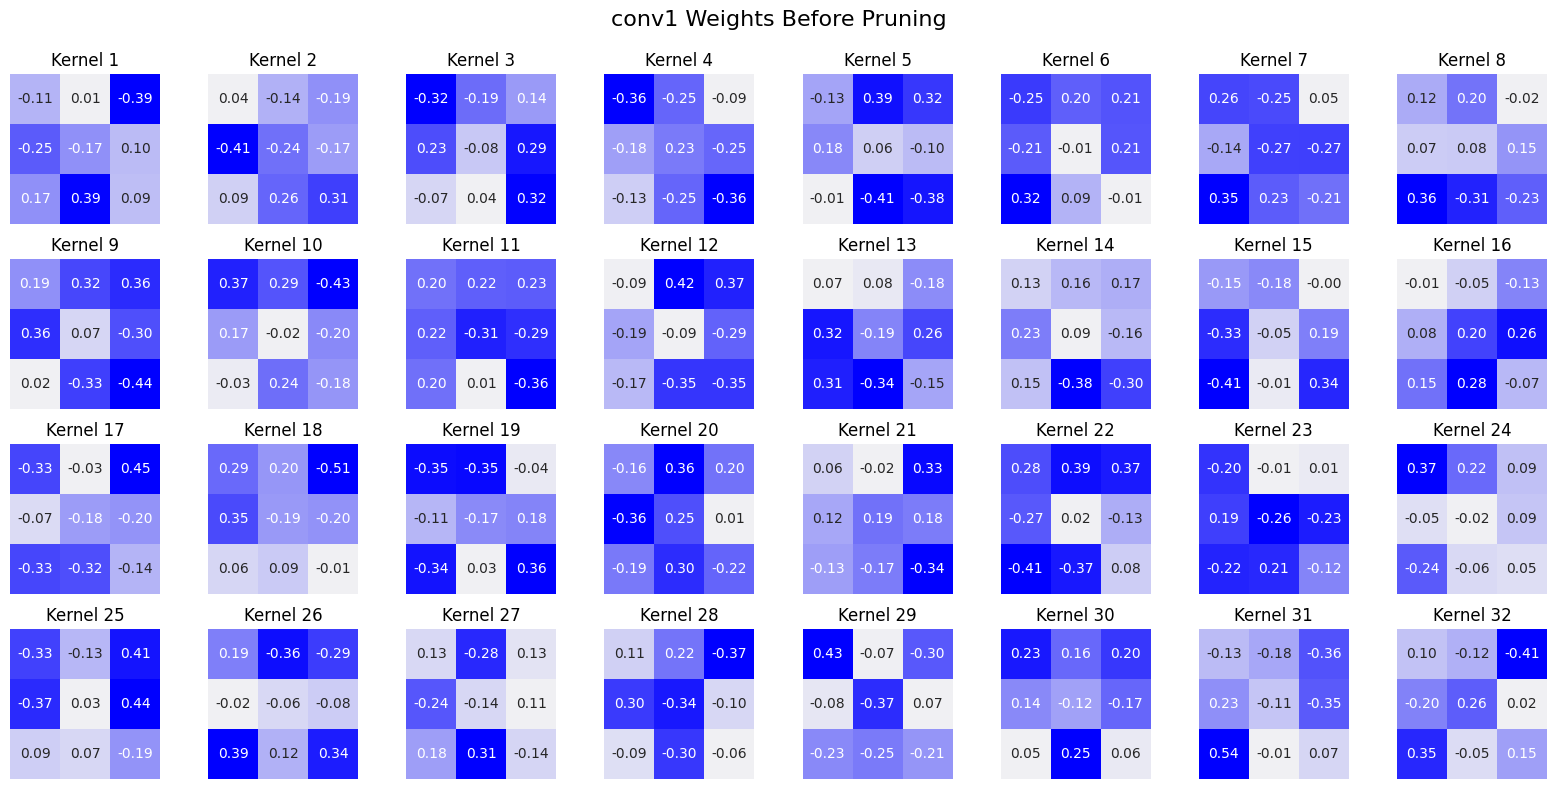

In [ ]:
# Visualize conv1
visualize_weights(model, "conv1.weight", "conv1 Weights Before Pruning")


# Let's Prune the Model and Re-Evaluate the Accuracy.

eval:   0%|          | 0/10 [00:00<?, ?it/s]

90.0% sparse model has accuracy=19.11%
90.0% sparse model has size=0.46 MiB, which is 9.98X smaller than the 4.58 MiB dense model


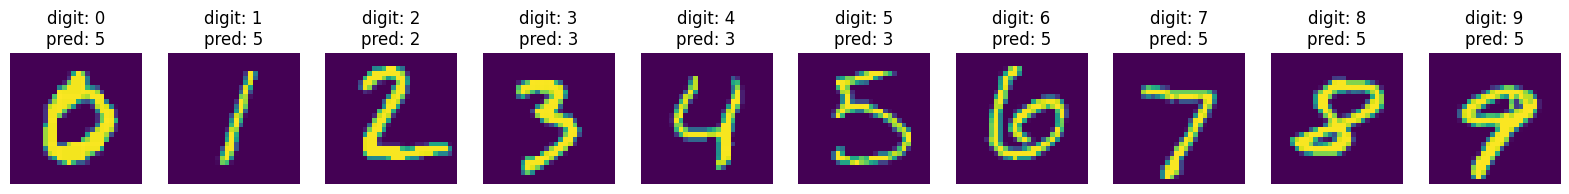

In [ ]:
sparsity = 0.9
pruner = FineGrainedPruner(model, sparsity)
pruner.apply(model)
sparse_model_accuracy = evaluate(model, dataloader['test'])
sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"{sparsity*100}% sparse model has accuracy={sparse_model_accuracy:.2f}%")
print(f"{sparsity*100}% sparse model has size={sparse_model_size/MiB:.2f} MiB, "
      f"which is {dense_model_size/sparse_model_size:.2f}X smaller than "
      f"the {dense_model_size/MiB:.2f} MiB dense model")
visualize(True)

# Now, Re-Visualize the conv1 Weights After Pruning!

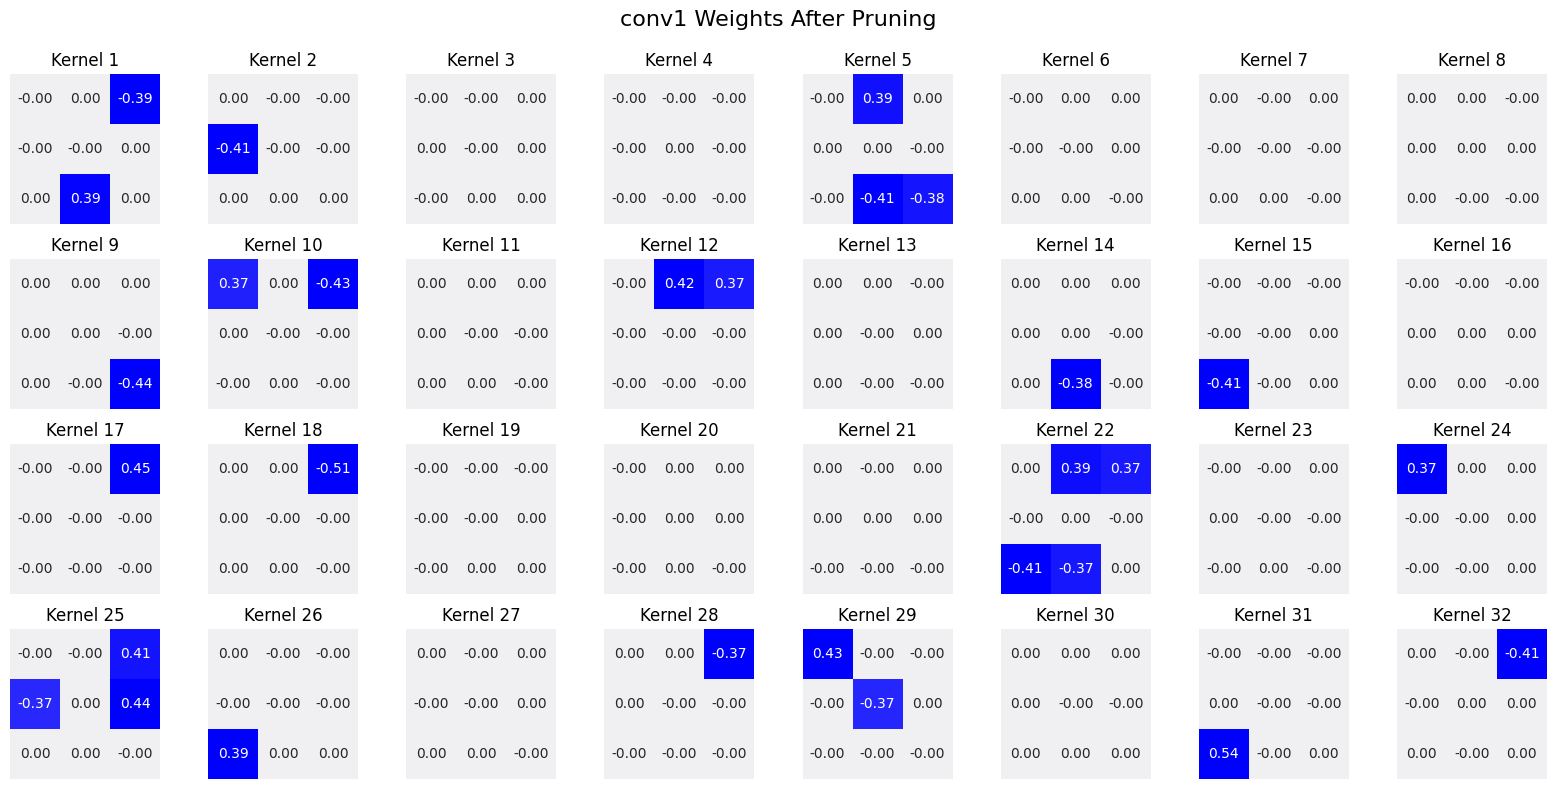

In [ ]:
visualize_weights(model, "conv1.weight", "conv1 Weights After Pruning")

# Let's Fine-tune the Pruned Model to Get Higher Accuracy

In [ ]:
num_finetune_epochs = 2
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)

best_sparse_checkpoint = dict()
best_sparse_accuracy = 0
print(f'Finetuning Fine-grained Pruned Sparse Model')
for epoch in range(num_finetune_epochs):
    # At the end of each train iteration, we have to apply the pruning mask
    #    to keep the model sparse during the training
    train(model, dataloader['train'], criterion, optimizer, scheduler,
          callbacks=[lambda: pruner.apply(model)])
    accuracy = evaluate(model, dataloader['test'])
    is_best = accuracy > best_sparse_accuracy
    if is_best:
        best_sparse_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
        best_sparse_accuracy = accuracy
    print(f'    Epoch {epoch+1} Sparse Accuracy {accuracy:.2f}% / Best Sparse Accuracy: {best_sparse_accuracy:.2f}%')


Finetuning Fine-grained Pruned Sparse Model


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 1 Sparse Accuracy 97.89% / Best Sparse Accuracy: 97.89%


train:   0%|          | 0/235 [00:00<?, ?it/s]

eval:   0%|          | 0/10 [00:00<?, ?it/s]

    Epoch 2 Sparse Accuracy 98.42% / Best Sparse Accuracy: 98.42%


eval:   0%|          | 0/10 [00:00<?, ?it/s]

90.0% sparse model has accuracy=98.42%
90.0% sparse model has size=0.46 MiB, which is 9.98X smaller than the 4.58 MiB dense model


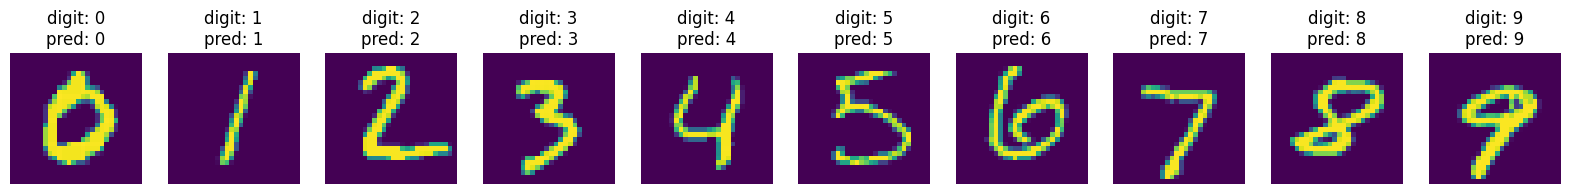

In [ ]:
model.load_state_dict(best_sparse_checkpoint['state_dict'])
sparse_model_accuracy = evaluate(model, dataloader['test'])
sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"{sparsity*100}% sparse model has accuracy={sparse_model_accuracy:.2f}%")
print(f"{sparsity*100}% sparse model has size={sparse_model_size/MiB:.2f} MiB, "
      f"which is {dense_model_size/sparse_model_size:.2f}X smaller than "
      f"the {dense_model_size/MiB:.2f} MiB dense model")
visualize(True)

# Visualize the conv1 Weights After Fine-Tuning!

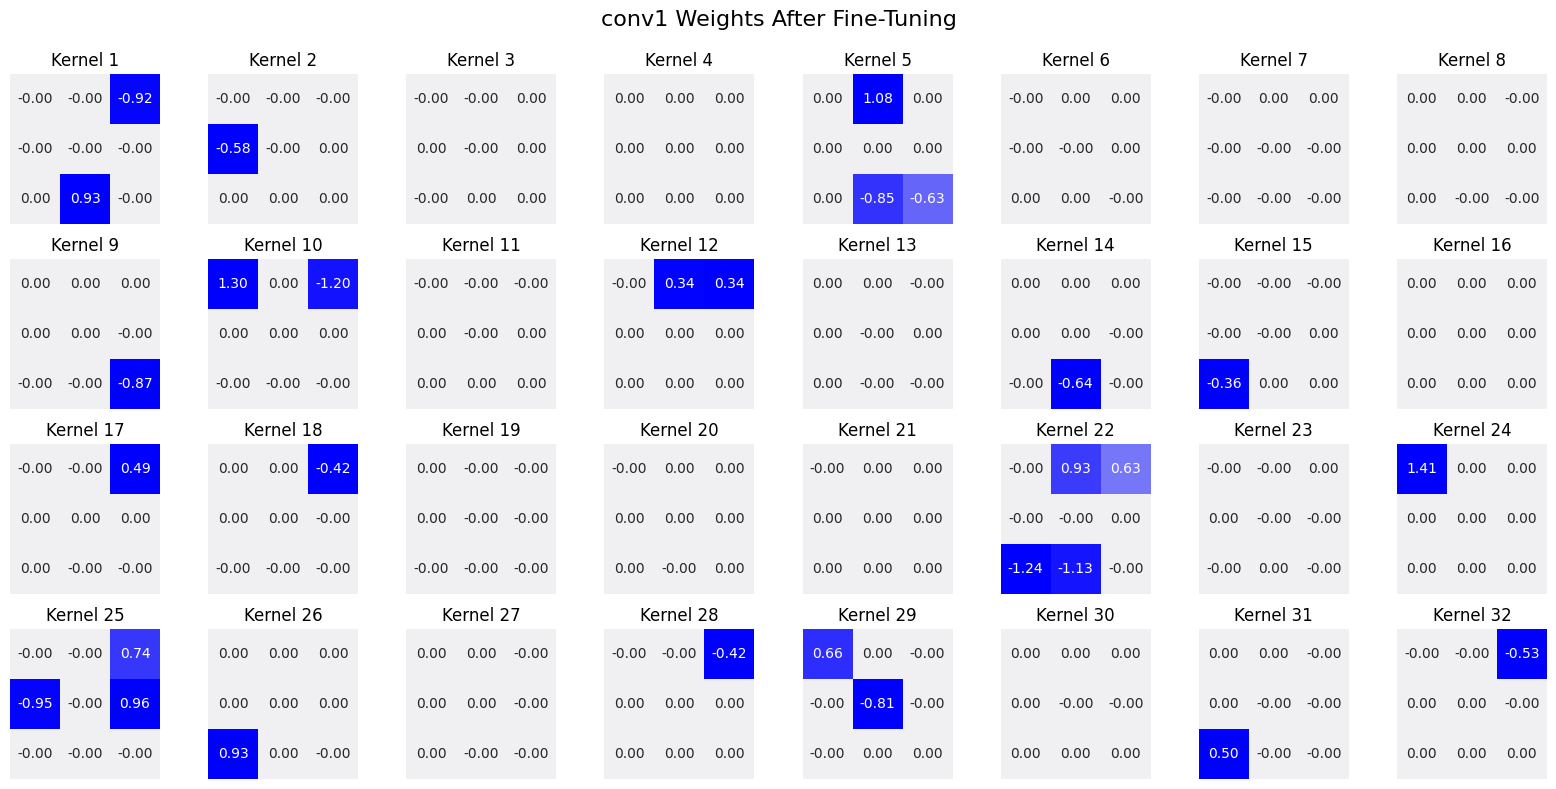

In [ ]:
visualize_weights(model, "conv1.weight", "conv1 Weights After Fine-Tuning")